<a href="https://www.kaggle.com/code/abhilash437/atari-breakout-v1?scriptVersionId=263966751" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This is a crude implementation of the paper https://arxiv.org/pdf/1312.5602
%pip install numpy torch "gymnasium[atari]" opencv-python matplotlib
%pip install tqdm wandb
%pip install ale-py
%pip install autorom
!AutoROM --accept-license

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

# Implementation of the paper "Playing Atari with Deep Reinforcement Learning"

"Playing Atari with Deep Reinforcement Learning" is a landmark 2013 paper by DeepMind researchers, introducing the Deep Q-Network (DQN) algorithm. The paper demonstrates how a convolutional neural network can learn to play Atari 2600 games directly from raw pixel inputs using reinforcement learning. The DQN combines Q-learning with deep neural networks and introduces experience replay and target networks to stabilize training. The approach achieved human-level performance on several Atari games, marking a significant advancement in combining deep learning with reinforcement learning.

Before implementing the Deep Q-Network (DQN) algorithm, it's important to set up the environment with the necessary packages. You will need Python 3, along with libraries such as NumPy for numerical operations, OpenAI Gym for the Atari environment, TensorFlow or PyTorch for building neural networks, and Matplotlib for visualization. To install the required packages, you can use the following command:

This cell performs the essential setup for the DQN (Deep Q-Network) training environment. It imports all the necessary libraries for deep reinforcement learning, including PyTorch for neural networks, Gymnasium for the environment, and utility libraries like NumPy and tqdm for progress tracking. 

It also sets up the device configuration, automatically selecting GPU (CUDA) if available, which is crucial for efficient training of deep networks. The cell defines key hyperparameters for the DQN algorithm:
- **BUFFER_CAPACITY**: Size of the experience replay buffer, which stores past transitions for training.
- **GAMMA**: Discount factor for future rewards, controlling the agent's foresight.
- **LR**: Learning rate for the optimizer.
- **ALPHA**: Smoothing constant, possibly for optimizers like RMSprop.
- **BATCH_SIZE**: Number of samples per training batch, larger for GPU acceleration.
- **EPSILON, EPS_DECAY, EPS_MIN**: Parameters for the epsilon-greedy exploration strategy, controlling how the agent balances exploration and exploitation.
- **NUM_EPISODES**: Total number of episodes to train the agent.
- **TARGET_UPDATE_FREQ**: Frequency (in steps) to update the target network, a key stability trick in DQN.

This configuration cell is foundational for reproducibility and performance tuning in deep RL experiments.

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque
from tqdm import trange

# =========================
# Device & Config
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, "GPUs:", torch.cuda.device_count())

BUFFER_CAPACITY = 100_000
GAMMA = 0.99
LR = 0.00025
ALPHA = 0.95
BATCH_SIZE = 256   # bigger for GPU
EPSILON = 1.0
EPS_DECAY = 0.9995
EPS_MIN = 0.01
NUM_EPISODES = 2000
TARGET_UPDATE_FREQ = 1000

Using device: cuda GPUs: 2


### DQN Network Architecture

This cell defines the core neural network used for the Deep Q-Network (DQN) agent. The network is implemented as a subclass of `torch.nn.Module` and is specifically designed to process stacked Atari frames (with 4 input channels) and output Q-values for each possible action in the environment.

**Key Components:**
- **Convolutional Layers:**
  - The network uses three convolutional layers to extract spatial and temporal features from the input frames. These layers are inspired by the original DQN paper:
    - The first layer has 32 filters, an 8x8 kernel, and a stride of 4.
    - The second layer has 64 filters, a 4x4 kernel, and a stride of 2.
    - The third layer has 64 filters, a 3x3 kernel, and a stride of 1.
- **Fully Connected Layers:**
  - After flattening the output of the convolutions, the network uses a fully connected layer with 512 units, followed by the final output layer that produces one Q-value per action.
- **Forward Pass:**
  - The input is normalized by dividing by 255.0 (to scale pixel values to [0, 1]).
  - ReLU activations are used after each layer for non-linearity.
  - The output is a vector of Q-values, one for each possible action, which the agent uses to select actions during training and evaluation.

This architecture enables the agent to learn complex policies directly from high-dimensional visual input, as demonstrated in the original DQN research.

In [3]:
class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = x / 255.0  # normalize here
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


### Replay Buffer Implementation

This cell implements the Replay Buffer, a crucial component in the DQN algorithm. The replay buffer stores past experiences (transitions) so that the agent can sample random batches for training, which helps break the correlation between consecutive experiences and stabilizes learning.

**Key Features:**
- **Preallocated Storage:**
  - The buffer preallocates tensors for states, next states, actions, rewards, and done flags directly on the GPU for efficient sampling and training.
- **Push Method:**
  - Adds a new transition (state, action, reward, next_state, done) to the buffer, overwriting old data in a circular fashion when the buffer is full.
- **Sample Method:**
  - Randomly samples a batch of transitions for training. This randomization is essential for the stability and efficiency of deep reinforcement learning.
- **Length Method:**
  - Returns the current number of stored transitions, which is useful for checking if enough data is available to start training.

By using a replay buffer, the DQN agent can learn from a diverse set of past experiences, improving sample efficiency and reducing the risk of divergence during training.

In [4]:
class ReplayBuffer:
    def __init__(self, capacity, obs_shape, device="cuda"):
        self.capacity = capacity
        self.device = device
        self.idx = 0
        self.full = False

        # preallocate tensors directly on GPU
        self.states = torch.zeros((capacity, *obs_shape), dtype=torch.uint8, device=device)
        self.next_states = torch.zeros((capacity, *obs_shape), dtype=torch.uint8, device=device)
        self.actions = torch.zeros((capacity,), dtype=torch.long, device=device)
        self.rewards = torch.zeros((capacity,), dtype=torch.float32, device=device)
        self.dones = torch.zeros((capacity,), dtype=torch.float32, device=device)

    def push(self, state, action, reward, next_state, done):
        self.states[self.idx] = torch.tensor(state, dtype=torch.uint8, device=self.device)
        self.next_states[self.idx] = torch.tensor(next_state, dtype=torch.uint8, device=self.device)
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.dones[self.idx] = float(done)

        self.idx = (self.idx + 1) % self.capacity
        if self.idx == 0:
            self.full = True

    def sample(self, batch_size):
        max_idx = self.capacity if self.full else self.idx
        idxs = torch.randint(0, max_idx, (batch_size,), device=self.device)
        return (
            self.states[idxs].to(torch.float32),
            self.actions[idxs],
            self.rewards[idxs],
            self.next_states[idxs].to(torch.float32),
            self.dones[idxs],
        )

    def __len__(self):
        return self.capacity if self.full else self.idx

In [5]:
def get_action(policy_net, state, epsilon, env):
    if random.random() < epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        q_values = policy_net(torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0))
        return q_values.argmax(dim=1).item()


### DQN Training Loop and Algorithm Explanation

This cell implements the main training loop for the Deep Q-Network (DQN) agent and encapsulates the core logic of the DQN algorithm.

**DQN Algorithm Overview:**
- DQN is a value-based reinforcement learning algorithm that uses a deep neural network to approximate the Q-function, which estimates the expected cumulative reward for taking an action in a given state and following the optimal policy thereafter.
- The algorithm introduces two key innovations for stability:
  1. **Experience Replay:** Stores past transitions in a replay buffer and samples random batches for training, breaking the correlation between consecutive experiences.
  2. **Target Network:** Maintains a separate target network for computing target Q-values, which is updated less frequently to stabilize learning.

**Training Loop Details:**
- For each episode, the environment is reset and the agent interacts with it until the episode ends.
- At each step:
  - The agent selects an action using an epsilon-greedy policy (balancing exploration and exploitation).
  - The environment returns the next state, reward, and done flag.
  - The transition is stored in the replay buffer.
  - If enough samples are available, a random batch is sampled from the buffer for training.
  - The policy network predicts Q-values for the current states and actions.
  - The target Q-values are computed using the target network and the Bellman equation:
    $$ Q_{target} = r + \gamma \max_{a'} Q_{target}(s', a') $$
  - The loss (typically MSE) between predicted and target Q-values is computed and backpropagated.
  - The target network is periodically updated with the policy network's weights.
  - Epsilon is decayed to reduce exploration over time.
- The loop tracks and logs rewards and losses for monitoring training progress.
- Model checkpoints are saved at regular intervals for recovery and evaluation.

In [6]:
def train(env, policy_net, target_net, replay_buffer, optimizer, loss_fn):
    rewards, losses = [], []
    global_step = 0
    epsilon = EPSILON

    pbar = trange(NUM_EPISODES, desc="Training", unit="ep")
    for episode in pbar:
        state, _ = env.reset()
        total_reward, done = 0, False
        episode_losses = []

        while not done:
            action = get_action(policy_net, state, epsilon, env)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # train if enough samples
            if len(replay_buffer) >= BATCH_SIZE:
                states, actions, rewards_b, next_states, dones = replay_buffer.sample(BATCH_SIZE)

                with torch.no_grad():
                    next_q = target_net(next_states).max(1)[0]
                    target_q = rewards_b + GAMMA * next_q * (1 - dones)

                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                loss = loss_fn(q_values, target_q)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 10.0)
                optimizer.step()

                episode_losses.append(loss.item())
                global_step += 1

                if global_step % TARGET_UPDATE_FREQ == 0:
                    target_net.load_state_dict(policy_net.state_dict())

            # epsilon decay
            epsilon = max(epsilon * EPS_DECAY, EPS_MIN)

        rewards.append(total_reward)
        if episode_losses:
            losses.append(np.mean(episode_losses))

        # logging
        avg_reward = np.mean(rewards[-100:])
        avg_loss = np.mean(losses[-100:]) if losses else 0
        pbar.set_postfix({
            "Reward": total_reward,
            "AvgReward": f"{avg_reward:.2f}",
            "Loss": f"{avg_loss:.4f}",
            "Eps": f"{epsilon:.3f}"
        })

        # save
        if episode % 500 == 0:
            torch.save({
                'episode': episode,
                'policy_net_state_dict': policy_net.state_dict(),
                'target_net_state_dict': target_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"checkpoint_{episode}.pth")

    return rewards, losses

In [7]:
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
env = gym.wrappers.RecordEpisodeStatistics(env)
env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.GrayScaleObservation(env)
env = gym.wrappers.FrameStack(env, 4)

obs_shape = env.observation_space.shape  # (4, 84, 84)
num_actions = env.action_space.n

# =========================
# Init networks
# =========================
policy_net = DQN(num_actions)
target_net = DQN(num_actions)

# ✅ Multi-GPU
if torch.cuda.device_count() > 1:
    print("2 GPUs found")
    policy_net = nn.DataParallel(policy_net)
    target_net = nn.DataParallel(target_net)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


2 GPUs found


/usr/local/lib/python3.11/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(rewards, losses, window=100):
    # Moving average for rewards
    rewards_mavg = np.convolve(rewards, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(15,5))

    # Rewards plot
    plt.subplot(1,2,1)
    plt.plot(rewards, label="Reward per Episode", alpha=0.6)
    plt.plot(range(window-1, len(rewards)), rewards_mavg, label=f"Moving Avg ({window})", color="red")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Episode Rewards")
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(losses, label="Loss", alpha=0.7)
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.show()


Training:   0%|          | 0/2000 [00:00<?, ?ep/s]/tmp/ipykernel_19/1491800310.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.states[self.idx] = torch.tensor(state, dtype=torch.uint8, device=self.device)
Training: 100%|██████████| 2000/2000 [5:30:51<00:00,  9.93s/ep, Reward=3, AvgReward=7.10, Loss=0.0080, Eps=0.010]


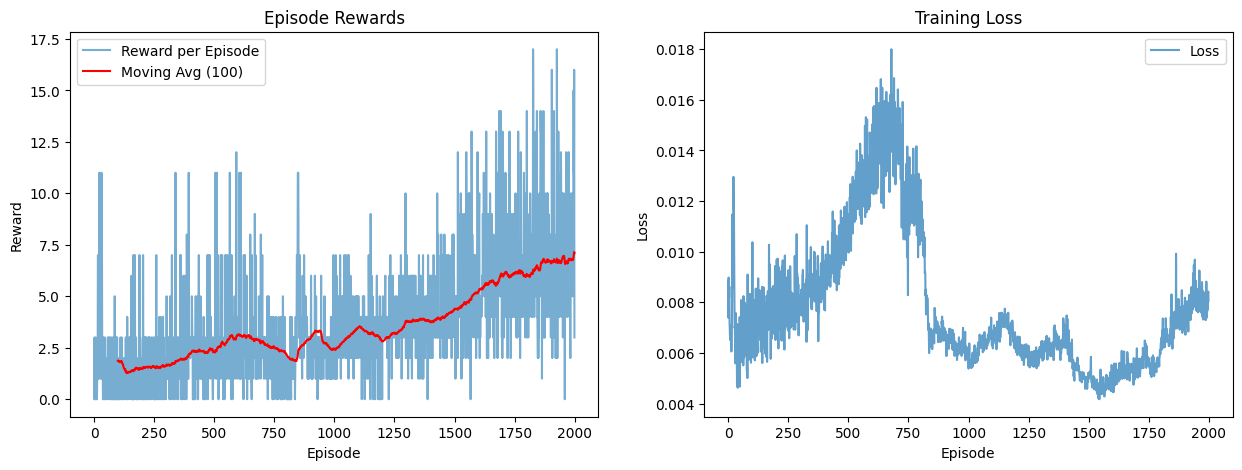

In [9]:
policy_net = policy_net.to(device)
target_net = target_net.to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=LR, alpha=ALPHA, eps=1e-2)
loss_fn = nn.MSELoss()

replay_buffer = ReplayBuffer(BUFFER_CAPACITY, obs_shape, device=device)

# =========================
# Run training
# =========================
rewards, losses = train(env, policy_net, target_net, replay_buffer, optimizer, loss_fn)
plot_training_curves(rewards, losses)

In [10]:
# checkpoint = torch.load("<checkpoint>.pth", map_location=device)
# policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
# target_net.load_state_dict(checkpoint['target_net_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_episode = checkpoint['episode'] + 1